In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'text.usetex': True}) # import to make plots nicer
%config InlineBackend.figure_format = 'svg' # import to make plots nicer

# Set global font size for title, x-label, and y-label
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
# Set global font size for x and y tick labels
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# Set global font size for the legend
plt.rcParams['legend.fontsize'] = 16


In [2]:
# import the labels for the train and test set

# https://pythonbasics.org/pickle/
import pickle
train_obj = open('data.obj', 'rb')
Y_train = pickle.load(train_obj)
train_obj.close()
test_obj = open('data_test.obj', 'rb')
Y_test = pickle.load(test_obj)
test_obj.close()

In [3]:
# load the reduced LDA data for train and test set

nb_train = pd.read_csv('final_train.csv')
nb_train['label'] = Y_train

nb_test = pd.read_csv('final_test.csv')
nb_test['label'] = Y_test

In [4]:
# divide train and test set into classes

nb_class_0_train = nb_train[nb_train['label'] == 'T-shirt/top']
nb_class_1_train = nb_train[nb_train['label'] == 'Trouser']
nb_class_2_train = nb_train[nb_train['label'] == 'Pullover']
nb_class_3_train = nb_train[nb_train['label'] == 'Dress']
nb_class_4_train = nb_train[nb_train['label'] == 'Shirt']

nb_class_0_test = nb_test[nb_test['label'] == 'T-shirt/top']
nb_class_1_test = nb_test[nb_test['label'] == 'Trouser']
nb_class_2_test = nb_test[nb_test['label'] == 'Pullover']
nb_class_3_test = nb_test[nb_test['label'] == 'Dress']
nb_class_4_test = nb_test[nb_test['label'] == 'Shirt']



In [5]:
# create list of classes

list_of_train_classes = [nb_class_0_train, nb_class_1_train, nb_class_2_train, nb_class_3_train, nb_class_4_train]

In [6]:
def Calculate_class_likelihood(df, label_1, label_2, x_1, x_2):
        # https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule
        # calculate IQR_1
        iqr_1 = (np.percentile(df[label_1], 75) - np.percentile(df[label_1], 25))  # https://stackoverflow.com/questions/58142399/defining-a-function-to-calculate-iqr-in-numpy
        # calculates width based on IQR_1
        width_1 = (2*iqr_1) / np.power(len(df[label_1]), (1/3))
        # find the optimal number of bins
        b_1 = round(df[label_1].max() - df[label_1].min() / width_1)

        # divides the class dataframe into segment of discrete intervals
        df_cut_1 = pd.cut(df[label_1], bins=b_1)
        # https://pandas.pydata.org/docs/reference/api/pandas.cut.html
        
        # creates new index
        df_cut_1_in = df_cut_1.reset_index()

        # returns the segment sorted
        df_cut_num_1 = df_cut_1.value_counts().sort_index()
        
        # extracts min and max of the segment
        cl_1_min = df_cut_1_in[label_1].min().left
        cl_1_max = df_cut_1_in[label_1].max().right
        
        
        # calculate IQR_2 
        iqr_2 = (np.percentile(df[label_2], 75) - np.percentile(df[label_2], 25)) # https://stackoverflow.com/questions/58142399/defining-a-function-to-calculate-iqr-in-numpy
        # calculates width based on IQR_2
        width_2 = (2*iqr_2) / np.power(len(df[label_2]), (1/3))
        # find the optimal number of bins
        b_2 = round(df[label_2].max() - df[label_2].min() / width_2)

        # divides the class dataframe into segment of discrete intervals
        df_cut_2 = pd.cut(df[label_2], bins=b_2)
        # https://pandas.pydata.org/docs/reference/api/pandas.cut.html
        
        # creates new index
        df_cut_2_in = df_cut_2.reset_index()

        # returns the segment sorted
        df_cut_num_2 = df_cut_2.value_counts().sort_index()

        # extracts min and max of the segment
        cl_2_min = df_cut_2_in[label_2].min().left
        cl_2_max = df_cut_2_in[label_2].max().right
        #h_2 = df_cut_2_in[label_2][0].length
        
        # if x_1 or x_2 is outside of the range of the histogram, returns 0
        if (x_1 > cl_1_max or x_1 < cl_1_min) or (x_2 > cl_2_max or x_2 < cl_2_min):
                return 0
        else:   # returns the likelihood of the observation belonging to a class 
                return((df_cut_num_1[x_1]/(len(df) * width_1)) * (df_cut_num_2[x_2] / (len(df) * width_2)))* len(df)/10000


In [7]:
def classify(class_prob):
        # finds the index of the highest probability in a list
        index_max = np.argmax(class_prob)
        label_of_classes = ['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Shirt']
        # if the index of the highest probability is 0, returns the class with highest prior (T-shirt/top)
        if label_of_classes[index_max] == 0:
                return 'T-shirt/top'
        else:
                return label_of_classes[index_max]

In [8]:
def Class_probabilities(label_1, label_2, x_1, x_2, list_of_classes):
        # list of likelihoods 
        likelihoods = []
        # for every index in list of a list of classes, calcualte the likelihood of a observation belonging to a class from a list of classes
        for i in list_of_classes:
                # calculate the class likelihood
                class_likelihood = Calculate_class_likelihood(i, label_1, label_2, x_1, x_2) 
                # save the class_likelihood into a list of likelihoods
                likelihoods.append(class_likelihood)
            
        # sum all the likelihoods up
        sum_the_likelihoods = np.sum(likelihoods)
        
        # list of final probabilities
        final_probabilities = []
        
        # finds a posterior probability of the sample in each class
        for j in likelihoods:
                # if the sum of likelihoods is 0, uses
                #a very small number in the division to prevent dvision by 0
                if sum_the_likelihoods == 0:
                        # https://stackoverflow.com/questions/19141432/python-numpy-machine-epsilon
                        epsilon = np.finfo(float).eps 
                        prb = np.divide(j, epsilon)
                        final_probabilities.append(prb)
                else:
                        prb = np.divide(j, sum_the_likelihoods)
                # save the probabilities into a list of final probabilities
                final_probabilities.append(prb)
        # call the classify function
        return  classify(final_probabilities)
        

In [9]:
# variables for the train set and test set

x_1 = nb_train['LDA1']
x_2 = nb_train['LDA2']

x_1_t = nb_test['LDA1']
x_2_t = nb_test['LDA2']

In [84]:
# probabilities for the train set 

train_prob = []
for i in range(len(x_1)):
        probs = Class_probabilities('LDA1', 'LDA2', x_1[i], x_2[i], list_of_train_classes)
        train_prob.append(probs)

0.2885314758382095
0.0
0.006937631932235783
0.008526038734226174
0.20168213785880768
0.5705842140039932: probability, 0.2885314758382095: likelihood, 0.5056772843634791: sum of likelihoods
0.0: probability, 0.0: likelihood, 0.5056772843634791: sum of likelihoods
0.013719485028813429: probability, 0.006937631932235783: likelihood, 0.5056772843634791: sum of likelihoods
0.016860632260668616: probability, 0.008526038734226174: likelihood, 0.5056772843634791: sum of likelihoods
0.39883566870652476: probability, 0.20168213785880768: likelihood, 0.5056772843634791: sum of likelihoods
Index 0
0
0.7352667955402565
0
0
0
0.0: probability, 0: likelihood, 0.7352667955402565: sum of likelihoods
1.0: probability, 0.7352667955402565: likelihood, 0.7352667955402565: sum of likelihoods
0.0: probability, 0: likelihood, 0.7352667955402565: sum of likelihoods
0.0: probability, 0: likelihood, 0.7352667955402565: sum of likelihoods
0.0: probability, 0: likelihood, 0.7352667955402565: sum of likelihoods
0.7

In [10]:
# probabilities for the train set 
test_prob = []
for i in range(len(x_1_t)):
        probs = Class_probabilities('LDA1', 'LDA2', x_1_t[i], x_2_t[i], list_of_train_classes)
        test_prob.append(probs)

In [11]:
# save test prob and train prob as pickle objects to prevent running the classification all the time 

# https://pythonbasics.org/pickle/

test_prob_obj = open('test_prob.obj', 'wb')
pickle.dump(test_prob, test_prob_obj)
test_prob_obj.close()

train_prob_obj = open('train_prob.obj', 'wb')
pickle.dump(train_prob, train_prob_obj)
train_prob_obj.close()

In [12]:
# load the pickeled list of probabilities 
# https://pythonbasics.org/pickle/
test_prob_obj = open('test_prob.obj', 'rb')
test_prob = pickle.load(test_prob_obj)
test_prob_obj.close()

train_prob_obj = open('train_prob.obj', 'rb')
train_prob = pickle.load(train_prob_obj)
train_prob_obj.close()


In [12]:
# prepare the daraframe of predicted and true label for the train and test set 
train_prob_df = pd.DataFrame({'predicted': train_prob, 'true label': Y_train})
test_prob_df = pd.DataFrame({'predicted': test_prob, 'true label': Y_test})

In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
# confusion matrix for the train set 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 2000x2000 with 0 Axes>

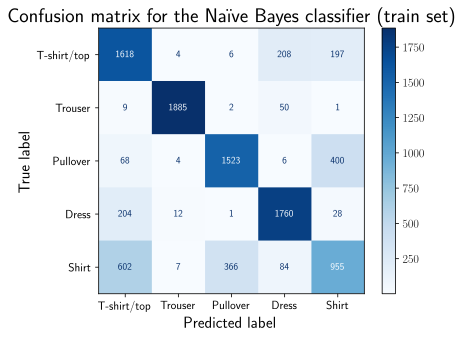

In [14]:

plt.figure(figsize=(20,20))
cm = confusion_matrix(train_prob_df['true label'], train_prob_df['predicted'],labels=['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Shirt'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Shirt'])
disp.plot(cmap='Blues')
plt.title('Confusion matrix for the Naïve Bayes classifier (train set)')
plt.savefig("confusion.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
# metrics for the trai nset 
from sklearn.metrics import precision_recall_fscore_support

In [18]:

precision_recall_fscore_support(train_prob_df['true label'], train_prob_df['predicted'], labels=['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Shirt'])


(array([0.64694122, 0.98587866, 0.8024236 , 0.83491461, 0.60404807]),
 array([0.79586818, 0.96815614, 0.76111944, 0.87780549, 0.47418073]),
 array([0.71371857, 0.97693703, 0.78122596, 0.855823  , 0.53129346]),
 array([2033, 1947, 2001, 2005, 2014], dtype=int64))

<Figure size 2000x2000 with 0 Axes>

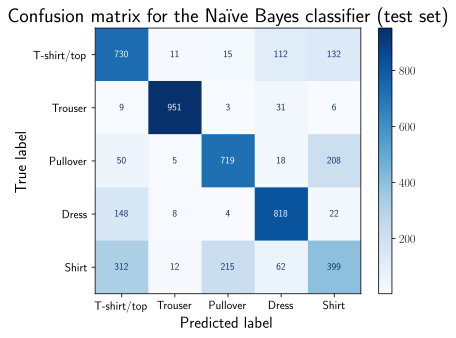

In [16]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
# confusion matrix for the test set 

plt.figure(figsize=(20,20))
cm = confusion_matrix(test_prob_df['true label'], test_prob_df['predicted'],labels=['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Shirt'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Shirt'])
disp.plot(cmap='Blues')
plt.title('Confusion matrix for the Naïve Bayes classifier (test set)')
plt.savefig("confusion_test.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
# metrics for the test set
precision_recall_fscore_support(test_prob_df['true label'], test_prob_df['predicted'], labels=['T-shirt/top','Trouser', 'Pullover', 'Dress', 'Shirt']).T

(array([0.58446757, 0.96352584, 0.75209205, 0.7857829 , 0.5202086 ]),
 array([0.73 , 0.951, 0.719, 0.818, 0.399]),
 array([0.64917741, 0.95722194, 0.73517382, 0.80156786, 0.4516129 ]),
 array([1000, 1000, 1000, 1000, 1000], dtype=int64))